In [1]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs
! unzip cuhk-face-sketch-database-cufs.zip

Streaming output truncated to the last 5000 lines.
  inflating: cropped_sketch/00726.jpg  
  inflating: cropped_sketch/00727.jpg  
  inflating: cropped_sketch/00728.jpg  
  inflating: cropped_sketch/00729.jpg  
  inflating: cropped_sketch/00730.jpg  
  inflating: cropped_sketch/00731.jpg  
  inflating: cropped_sketch/00732.jpg  
  inflating: cropped_sketch/00733.jpg  
  inflating: cropped_sketch/00734.jpg  
  inflating: cropped_sketch/00735.jpg  
  inflating: cropped_sketch/00736.jpg  
  inflating: cropped_sketch/00737.jpg  
  inflating: cropped_sketch/00738.jpg  
  inflating: cropped_sketch/00739.jpg  
  inflating: cropped_sketch/00740.jpg  
  inflating: cropped_sketch/00741.jpg  
  inflating: cropped_sketch/00742.jpg  
  inflating: cropped_sketch/00743.jpg  
  inflating: cropped_sketch/00744.jpg  
  inflating: cropped_sketch/00745.jpg  
  inflating: cropped_sketch/00746.jpg  
  inflating: cropped_sketch/00747.jpg  
  inflating: cropped_sketch/00749.jpg  
  inflating: cropped_sketch/0

# FINAL THINGGGGGGGGGGG


In [3]:
%pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.2 MB/s eta 0:00:00


In [4]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Configuration
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
LATENT_DIM = 128
VAE_LR = 1e-4
GEN_LR = 1e-4
DISC_LR = 1e-4
LAMBDA_CYCLE = 10
EPOCHS = 25
BATCH_SIZE = 32

# Set the directories for normal and sketch images
REAL_IMAGES_DIR = '/content/photos'
PENCIL_SKETCHES_DIR = '/content/sketches'

# Use wildcards to match all image files in the directories
REAL_IMAGES_PATH = os.path.join(REAL_IMAGES_DIR, '*')
PENCIL_SKETCHES_PATH = os.path.join(PENCIL_SKETCHES_DIR, '*')

def load_images(path, target_size):
    images = []
    for img_path in glob.glob(path):
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img)
        img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
        images.append(img)
    return np.array(images)

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        real_images, pencil_sketches = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(real_images)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(real_images, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
                )
            )
            vae_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(vae_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(vae_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

def build_encoder(latent_dim, input_shape):
    encoder_inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

def build_decoder(latent_dim, output_shape):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(64 * 64 * 32, activation="relu")(x)
    x = layers.Reshape((64, 64, 32))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(output_shape[2], 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class HybridGAN(keras.Model):
    def __init__(self, vae, generator, discriminator, lambda_cycle=10, **kwargs):
        super(HybridGAN, self).__init__(**kwargs)
        self.vae = vae
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_cycle = lambda_cycle
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.gen_loss_tracker,
            self.disc_loss_tracker,
        ]

    def compile(self, vae_optimizer, gen_optimizer, disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(HybridGAN, self).compile()
        self.vae_optimizer = vae_optimizer
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, data):
        real_images, pencil_sketches = data

        # VAE training
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.vae.encoder(real_images)
            reconstruction = self.vae.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(real_images, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
                )
            )
            vae_loss = reconstruction_loss + kl_loss
        vae_grads = tape.gradient(vae_loss, self.vae.trainable_weights)
        self.vae_optimizer.apply_gradients(zip(vae_grads, self.vae.trainable_weights))

        # GAN training
        with tf.GradientTape(persistent=True) as tape:
            # Generator forward pass
            fake_sketches = self.generator(real_images, training=True)
            cycled_images = self.generator(fake_sketches, training=True)

            same_sketches = self.generator(pencil_sketches, training=True)

            disc_real_sketches = self.discriminator(pencil_sketches, training=True)
            disc_fake_sketches = self.discriminator(fake_sketches, training=True)

            # Generator loss
            # Create labels for the fake images (we want the generator to fool the discriminator)
            valid = tf.ones_like(disc_fake_sketches)
            gen_loss = self.gen_loss_fn(valid, disc_fake_sketches)

            cycle_loss = self.cycle_loss_fn(real_images, cycled_images)
            identity_loss = self.identity_loss_fn(pencil_sketches, same_sketches)
            total_gen_loss = gen_loss + self.lambda_cycle * cycle_loss + self.lambda_cycle * identity_loss

            # Discriminator loss
            fake = tf.zeros_like(disc_fake_sketches)
            real_loss = self.disc_loss_fn(valid, disc_real_sketches)
            fake_loss = self.disc_loss_fn(fake, disc_fake_sketches)
            disc_loss = (real_loss + fake_loss) * 0.5

        # Apply gradients
        gen_grads = tape.gradient(total_gen_loss, self.generator.trainable_weights)
        disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_weights)

        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        self.total_loss_tracker.update_state(total_gen_loss + disc_loss)
        self.gen_loss_tracker.update_state(total_gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
        }

def build_generator(img_shape):
    inputs = layers.Input(shape=img_shape)
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    OUTPUT_CHANNELS = 3
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)

def build_discriminator(img_shape):
    inputs = layers.Input(shape=img_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(512, 4, strides=2, padding='same', use_bias=False)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tfa.layers.InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

# Load real images and pencil sketches
real_images = load_images(REAL_IMAGES_PATH, (IMG_HEIGHT, IMG_WIDTH))
pencil_sketches = load_images(PENCIL_SKETCHES_PATH, (IMG_HEIGHT, IMG_WIDTH))

# Build and compile VAE
encoder = build_encoder(LATENT_DIM, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
decoder = build_decoder(LATENT_DIM, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(VAE_LR))

# Build and compile generator and discriminator
generator = build_generator((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
discriminator = build_discriminator((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Build and compile the hybrid GAN model
gan = HybridGAN(vae, generator, discriminator, lambda_cycle=LAMBDA_CYCLE)
gan.compile(
    vae_optimizer=tf.keras.optimizers.Adam(VAE_LR),
    gen_optimizer=tf.keras.optimizers.Adam(GEN_LR),
    disc_optimizer=tf.keras.optimizers.Adam(DISC_LR),
    gen_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    disc_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    cycle_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    identity_loss_fn=tf.keras.losses.MeanAbsoluteError()
)

dataset = tf.data.Dataset.from_tensor_slices((real_images, pencil_sketches))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(real_images)).batch(BATCH_SIZE)

# Update the fit method call
gan.fit(
    dataset,
    epochs=EPOCHS
)


# # Train the model
# gan.fit(
#     (real_images, pencil_sketches),
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE
# )


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Epoch 1/25
6/6 [==============================] - 90s 6s/step - total_loss: 14.2828 - gen_loss: 13.5139 - disc_loss: 0.7690
Epoch 2/25
6/6 [==============================] - 12s 2s/step - total_loss: 12.4055 - gen_loss: 11.8227 - disc_loss: 0.5827
Epoch 3/25
6/6 [==============================] - 12s 2s/step - total_loss: 11.2781 - gen_loss: 10.7904 - disc_loss: 0.4877
Epoch 4/25
6/6 [==============================] - 12s 2s/step - total_loss: 10.4289 - gen_loss: 10.0216 - disc_loss: 0.4073
Epoch 5/25
6/6 [==============================] - 12s 2s/step - total_loss: 9.6904 - gen_loss: 9.3174 - disc_loss: 0.3730
Epoch 6/25
6/6 [==============================] - 12s 2s/step - total_loss: 9.0866 - gen_loss: 8.6614 - disc_loss: 0.4251
Epoch 7/25
6/6 [==============================] - 12s 2s/step - total_loss: 8.6112 - gen_loss: 8.1563 - disc_loss: 0.4550
Epoch 8/25
6/6 [==============================] - 12s 2s/step - total_loss: 8.0861 - gen_loss: 7.6642 - disc_loss: 0.4220
Epoch 9/25
6/6 [

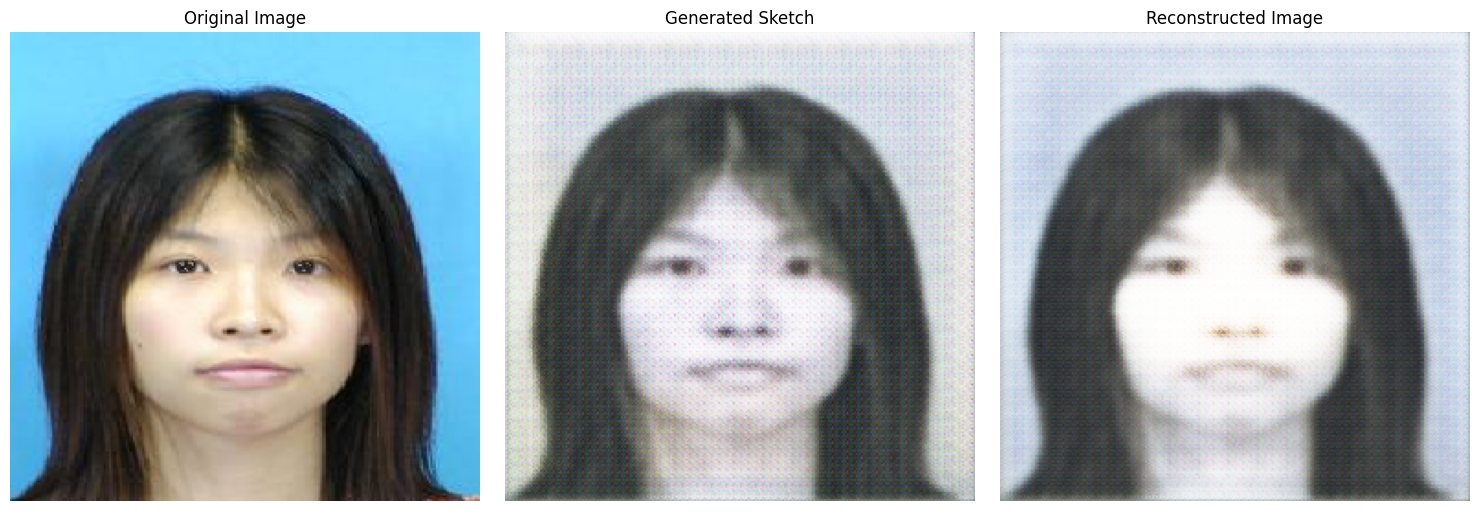

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
    return np.expand_dims(img, axis=0)  # Add batch dimension

def deprocess_image(img):
    img = (img + 1.0) * 127.5  # Denormalize
    return np.clip(img, 0, 255).astype(np.uint8)

def test_single_image(gan, image_path):
    # Load and preprocess the test image
    test_image = preprocess_image(image_path)

    # Generate sketch using the generator
    generated_sketch = gan.generator(test_image, training=False)

    # Optionally, reconstruct the image from the sketch
    reconstructed_image = gan.generator(generated_sketch, training=False)

    # Deprocess images for display
    original_image = deprocess_image(test_image[0])
    generated_sketch = deprocess_image(generated_sketch[0])
    reconstructed_image = deprocess_image(reconstructed_image[0])

    # Display results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(generated_sketch, cmap='gray')
    axs[1].set_title('Generated Sketch')
    axs[1].axis('off')

    axs[2].imshow(reconstructed_image)
    axs[2].set_title('Reconstructed Image')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
image_path = '/content/photos/f-005-01.jpg'
test_single_image(gan, image_path)

In [ ]:
gan.save_weights('hybrid_gan_weights_final.h5')

ValueError: Unable to create dataset (name already exists)